In [10]:
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

# Directory to save the downloaded file
save_directory = "../input_data"

# Download the file
wget.download(url, out=save_directory)

100% [..........................................................................] 1423529 / 1423529

'../input_data/housing.csv'

In [8]:
housing_df = pd.read_csv('../input_data/housing.csv')

In [9]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: xlabel='median_house_value', ylabel='Count'>

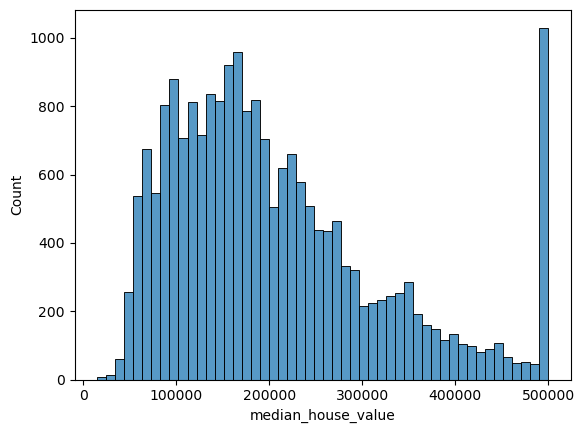

In [11]:
# Look at the median_house_value variable. Does it have a long tail?
sns.histplot(housing_df.median_house_value, bins=50)

In [22]:
# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = housing_df[housing_df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df = df.drop(columns=['ocean_proximity'])

In [23]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [24]:
df.count()

longitude             15687
latitude              15687
housing_median_age    15687
total_rooms           15687
total_bedrooms        15530
population            15687
households            15687
median_income         15687
median_house_value    15687
dtype: int64

### Question 1: There's one feature with missing values. What is it?

In [31]:
null_counts = df.isnull().sum()

# Filter out columns with null values
columns_with_nulls = null_counts[null_counts > 0]

# Show columns with null values
print(columns_with_nulls)

total_bedrooms    157
dtype: int64


### Question 2: What's the median (50% percentile) for variable 'population'?

In [34]:
df.population.median()

1195.0

In [53]:
# Prepare and split the dataset
# Shuffle the dataset (the filtered one you created above), use seed 42
n = len(df)

# Split your data in train/val/test sets, with 60%/20%/20% distribution.
n_val = int(n * .20)
n_test = int(n * .20)
n_train = n - (n_val + n_test)

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[:n_train]
df_val = df.iloc[n_train: n_train+n_val]
df_test = df.iloc[n_train+n_val:]

In [54]:
df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16258,-121.26,37.96,43.0,940.0,208.0,690.0,181.0,2.3056,62300.0
16259,-121.26,37.97,41.0,2398.0,448.0,1143.0,444.0,3.0352,69800.0
16260,-121.25,37.97,41.0,855.0,189.0,716.0,206.0,2.0375,75000.0
16261,-121.26,37.96,35.0,1511.0,316.0,892.0,304.0,1.7898,63500.0
16262,-121.25,37.95,40.0,1703.0,362.0,1208.0,373.0,2.0817,55300.0


In [55]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [56]:
# Apply the log transformation to the median_house_value variable using the np.log1p() function.
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [57]:
y_val

array([12.45176407, 11.8115549 , 12.14685859, ..., 10.78520754,
       10.82974842, 11.0524919 ])

In [65]:
# deal with missing values for the column total_bedrooms
# 1.  Use mean of this variable to fill missing values
total_bedrooms_mean = df_train['total_bedrooms'].mean()
df_train_fillna_mean = df_train.copy()
df_train_fillna_mean['total_bedrooms'].fillna(total_bedrooms_mean, inplace = True)

# 2. Use 0 to fill missing values
df_train_fillna_zero = df_train.copy()
df_train_fillna_zero['total_bedrooms'].fillna(0, inplace = True)

In [83]:
# For each, train a linear regression model without regularization 
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [84]:
# Train data having mean imputation
w_0_fillna_mean, w_full_fillna_mean = train_linear_regression(df_train_fillna_mean, y_train)
# Train data having zero imputation
w_0_fillna_zero, w_full_fillna_zero = train_linear_regression(df_train_fillna_zero, y_train)

In [76]:
# Predictions for data having mean value imputation
y_pred_fillna_mean = w_0_fillna_mean + df_train_fillna_mean.dot(w_full_fillna_mean)
# Predictions for data having zero value imputation
y_pred_fillna_zero = w_0_fillna_zero + df_train_fillna_zero.dot(w_full_fillna_zero)

In [96]:
# rmse
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return round(np.sqrt(mse), 5)

In [81]:
rmse(y_train, y_pred_fillna_mean)

0.17

In [82]:
rmse(y_train, y_pred_fillna_zero)

0.17

In [89]:
# For each, train a linear regression model with regularization 
def train_linear_regression_reg(X, y, r=.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [94]:
for r in [.00001, .0001, .001, .01, .1, 1, 10]:
    w_0_fillna_mean, w_full_fillna_mean = train_linear_regression_reg(df_train_fillna_mean, y_train)
    y_pred_fillna_mean = w_0_fillna_mean + df_train_fillna_mean.dot(w_full_fillna_mean)
    score = rmse(y_train, y_pred_fillna_mean)
    print(f"{r}, \t {score}, \t {w_0_fillna_mean}")

1e-05, 	 0.173, 	 4.820834331731365
0.0001, 	 0.173, 	 4.820834331731365
0.001, 	 0.173, 	 4.820834331731365
0.01, 	 0.173, 	 4.820834331731365
0.1, 	 0.173, 	 4.820834331731365
1, 	 0.173, 	 4.820834331731365
10, 	 0.173, 	 4.820834331731365


In [97]:
for r in [.00001, .0001, .001, .01, .1, 1, 10]:
    w_0_fillna_zero, w_full_fillna_zero = train_linear_regression(df_train_fillna_zero, y_train)
    y_pred_fillna_zero = w_0_fillna_zero + df_train_fillna_zero.dot(w_full_fillna_zero)
    score = rmse(y_train, y_pred_fillna_zero)
    print(f"{r}, \t {score}, \t {w_0_fillna_zero}")

1e-05, 	 0.17301, 	 4.8786011591005245
0.0001, 	 0.17301, 	 4.8786011591005245
0.001, 	 0.17301, 	 4.8786011591005245
0.01, 	 0.17301, 	 4.8786011591005245
0.1, 	 0.17301, 	 4.8786011591005245
1, 	 0.17301, 	 4.8786011591005245
10, 	 0.17301, 	 4.8786011591005245


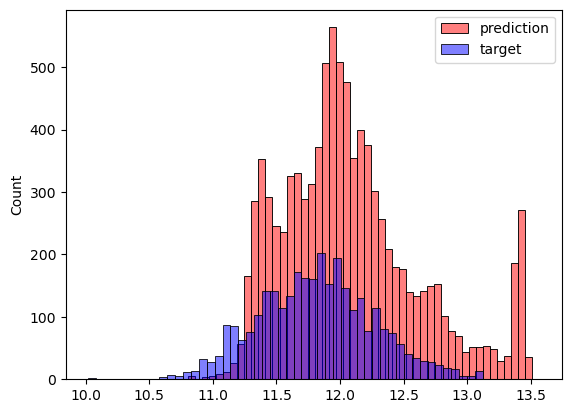

In [99]:
sns.histplot(y_pred_fillna_mean, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()